## Code to generate Figure S5 graphics
(A & B) For each PAGE4 and Ash1, we calculated the trajectory-averaged interresidue distances for the phosphorylated and phosphomimetic sequences using soursop and stored them as csv files. This code calculates relative distance maps using the unmodified map as the reference. In the distance calculations, data points for distances between i and j when i = j are excluded.

(C) 

(D)

This code loads csv files from 'data/'.

In [20]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
import scipy.stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
## load csv files with distance maps ##

Ash1_dm = np.loadtxt('data/Ash1_dm.csv')
pAsh1_dm = np.loadtxt('data/pAsh1_dm.csv')
eAsh1_dm= np.loadtxt('data/eAsh1_dm.csv')

PAGE4_dm = np.loadtxt('data/PAGE4_dm.csv')
pPAGE4_dm = np.loadtxt('data/pPAGE4_dm.csv')
ePAGE4_dm= np.loadtxt('data/ePAGE4_dm.csv')

In [4]:
## function to generate relative distance maps & account for NaN values##
# 'upper_seq' map is the numerator of the upper left triangle
# 'lower_seq' map is the numerator for the lower right triangle
# 'ref_map' specifies the reference dataset

def dist_mapper(upper_seq, lower_seq, ref_map):
    upper = upper_seq / ref_map
    upper = np.nan_to_num(upper, nan = 0)
    
    lower = lower_seq / ref_map
    lower = np.nan_to_num(lower, nan = 0)
    
    full_square = upper + lower.transpose()
    
    squareT = full_square.transpose()
    masked_array = np.ma.masked_where(squareT == 0, squareT)
    
    return masked_array

In [5]:
## use above function to calculate relative distance maps (rdm) to be plotted ##

Ash1_rdm = dist_mapper(eAsh1_dm, pAsh1_dm, Ash1_dm)
PAGE4_rdm = dist_mapper(ePAGE4_dm, pPAGE4_dm, PAGE4_dm)

/home/usher/miniconda3/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/usher/miniconda3/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


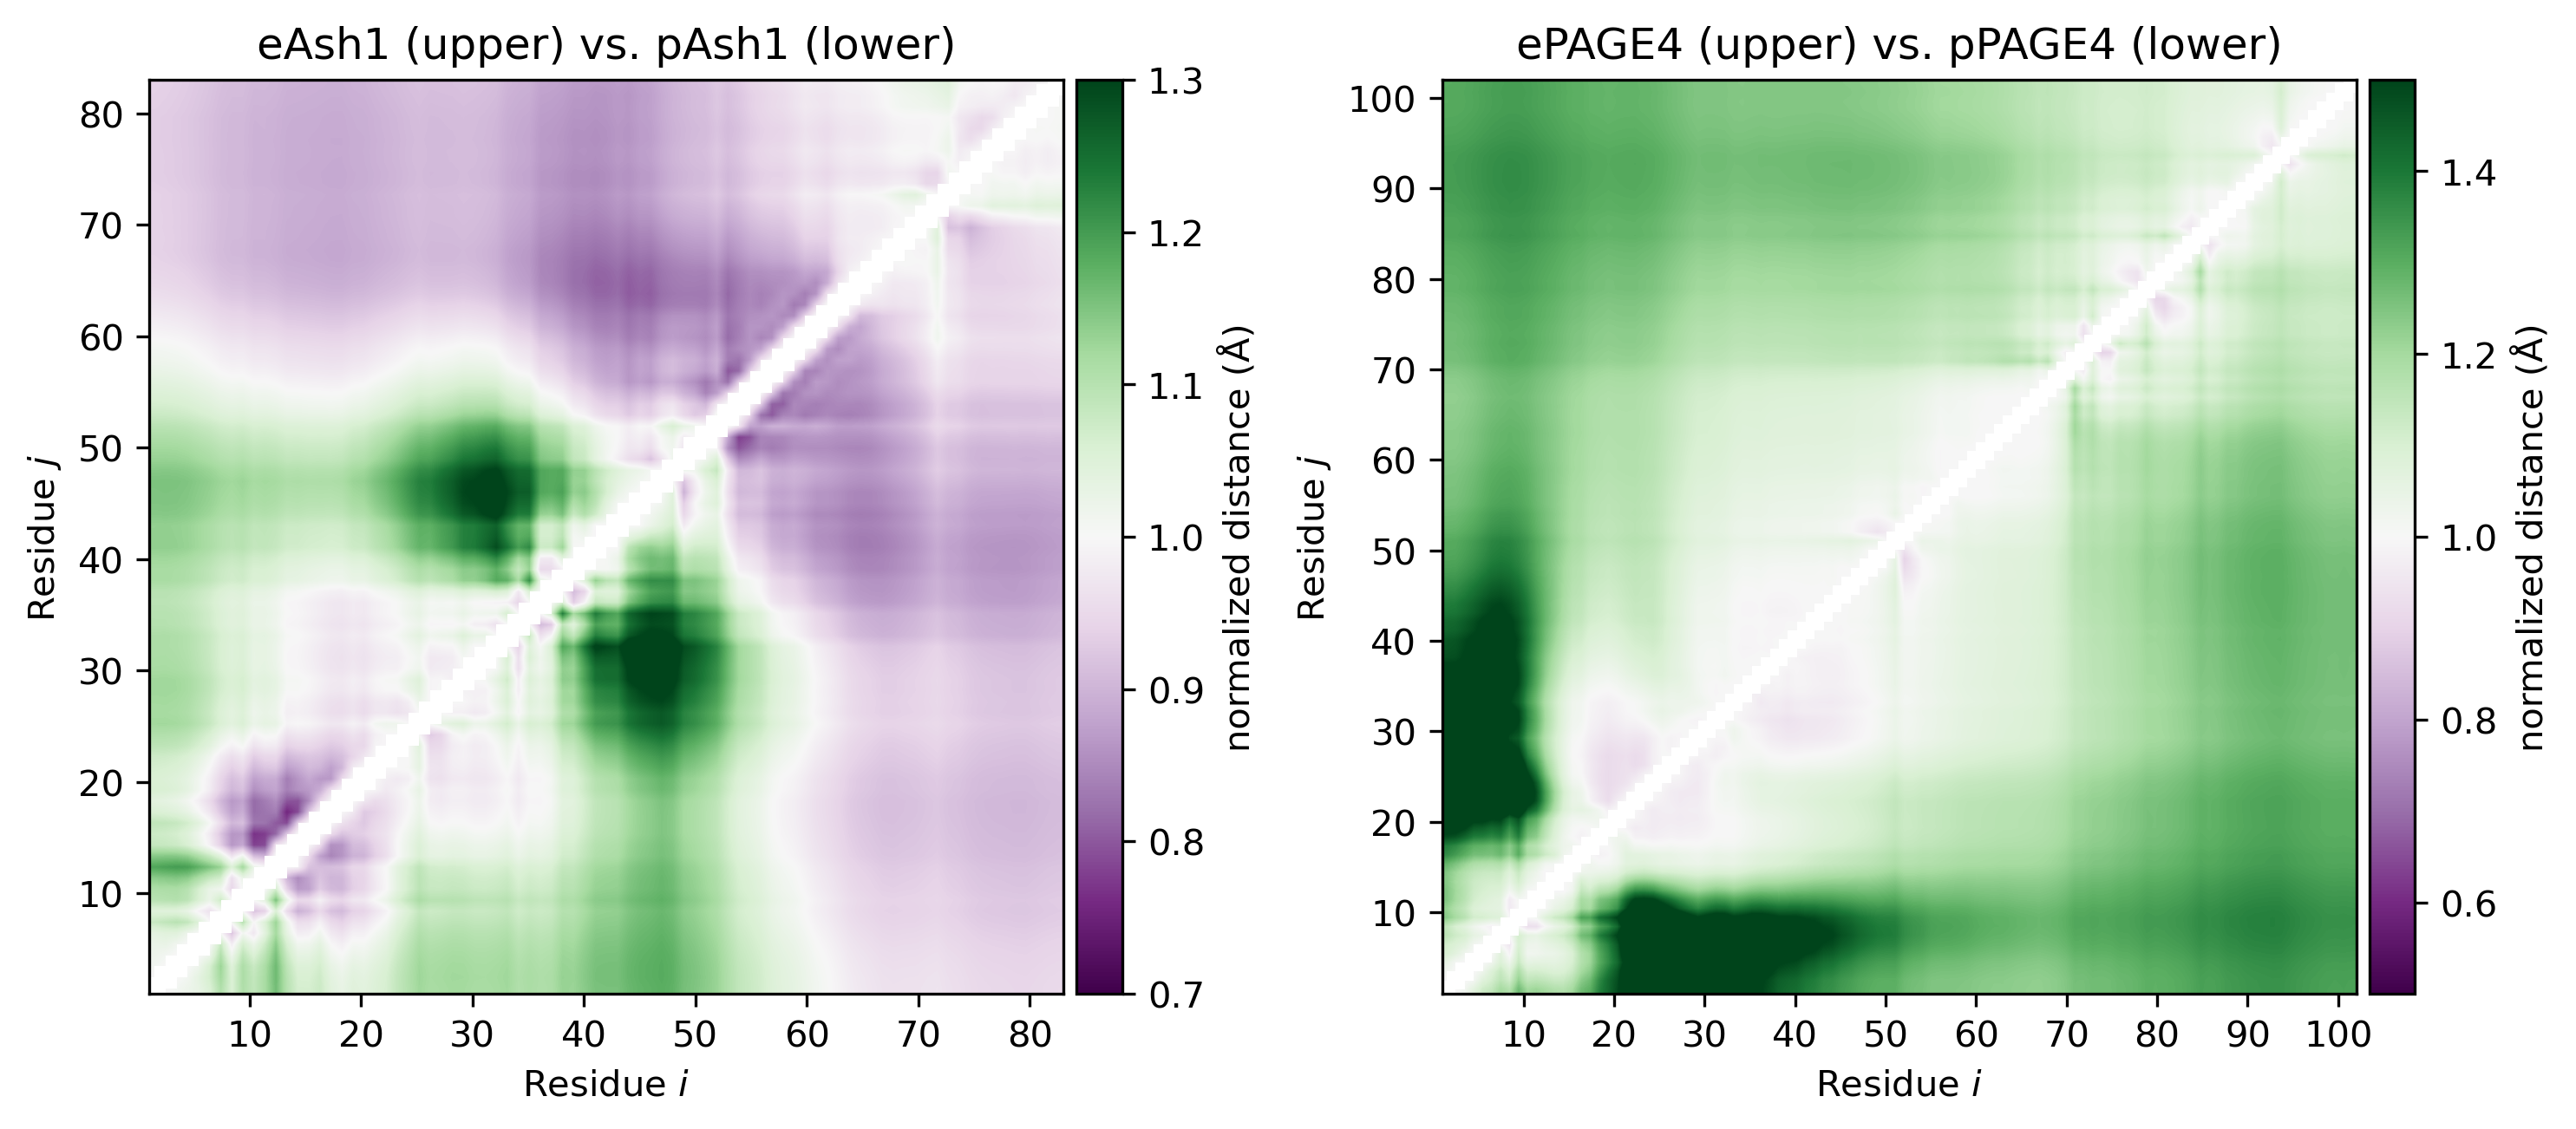

In [9]:
## generate relative distance map graphics (PANEL A-B) ##

fig, axes = plt.subplots(1, 2, figsize = (10, 5), dpi = 300)

titles = ['eAsh1 (upper) vs. pAsh1 (lower)', 'ePAGE4 (upper) vs. pPAGE4 (lower)']
datasets = [Ash1_rdm, PAGE4_rdm]
vmaxs = [1.3, 1.5]
vmins = [0.7, 0.5]

# set up colormap #
cmap = copy.copy(cm.get_cmap("PRGn"))

for x in range(2):
    max_extent = datasets[x].shape[0]
    im = axes[x].imshow(datasets[x], cmap = cmap, interpolation = 'bilinear', origin = 'lower', 
                 extent = [1, max_extent, 1, max_extent], vmax = vmaxs[x], vmin = vmins[x])
    axes[x].set_ylabel('Residue $j$')
    axes[x].set_xlabel('Residue $i$')
    axes[x].set_xticks(np.arange(0, max_extent+1, 10), fontsize = 10)
    axes[x].set_yticks(np.arange(0, max_extent+1, 10), fontsize = 10)
    axes[x].set_xlim([1, max_extent])
    axes[x].set_ylim([1, max_extent])
    axes[x].set_title(str(titles[x]))
    divider = make_axes_locatable(axes[x])
    cax = divider.append_axes("right", size = "5%", pad = 0.05)
    cb = fig.colorbar(im, cax = cax)
    cb.set_label('normalized distance (Å)')

plt.tight_layout()

plt.savefig('phosphomimetic_dist_maps_S5A-B.pdf', format = 'pdf', dpi = 300)

plt.show()

In [11]:
## load files containing NCPR, Rg, and Rg std deviation for the phosphoforms described in Tables S4 and S5 

Ash1_Rgs_NCPRs = np.loadtxt('data/ash1_ncpr_Rgs.txt')
PAGE4_Rgs_NCPRs = np.loadtxt('data/page4_ncpr_Rgs.txt')

# values for normalization of Rg values for different IDR lengths from AFRC reference 
Np = 25.18
Na = 22.82

In [13]:
## prepare datasets for linear regression
xP = PAGE4_Rgs_NCPRs[:,0]
yP = PAGE4_Rgs_NCPRs[:,1] / Np
errP = PAGE4_Rgs_NCPRs[:,2] / Np

xA = Ash1_Rgs_NCPRs[:,0]
yA = Ash1_Rgs_NCPRs[:,1] / Na
errA = Ash1_Rgs_NCPRs[:,2] / Na

In [16]:
## perform linear fits ##
# P == PAGE4
slopeP, interceptP, rP, pP, stderrP = scipy.stats.linregress(xP, yP)

# A == Ash1
slopeA, interceptA, rA, pA, stderrA = scipy.stats.linregress(xA, yA)

# remake y = mx + b with fitted parameters for plot
yPf = slopeP * xP + interceptP
yAf = slopeA * xA + interceptA

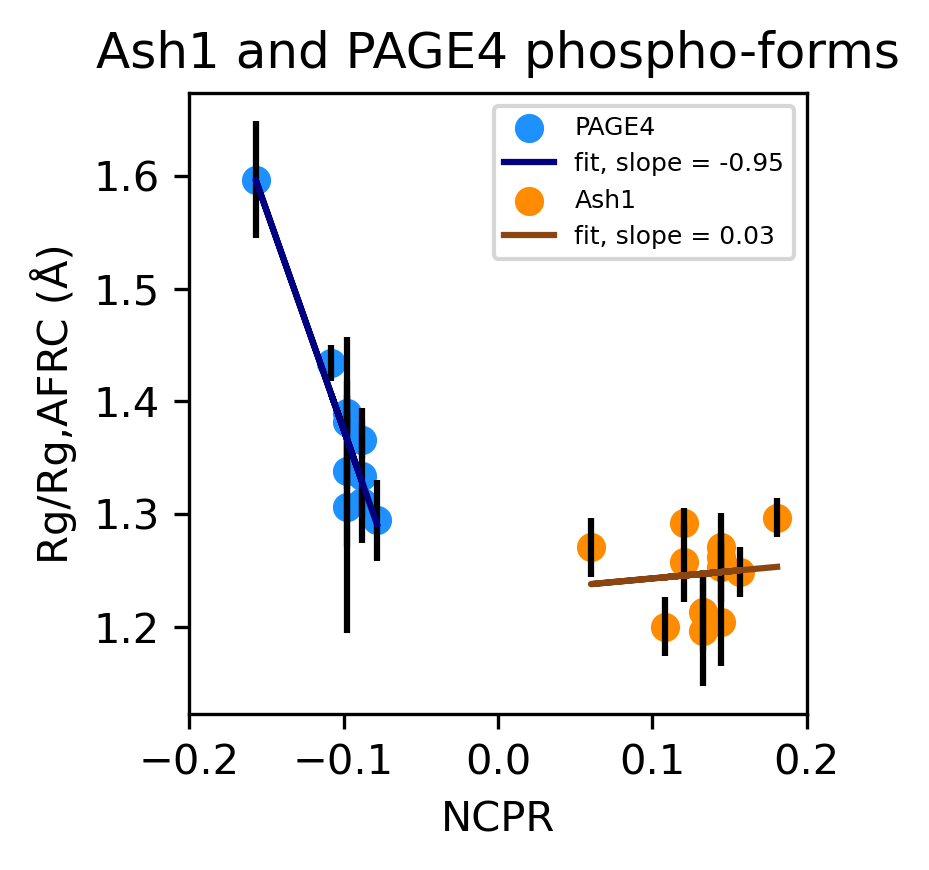

In [19]:
## generate plot of both linear fits and data points ##
plt.figure(num = None, figsize = (3, 3), dpi = 300, facecolor = 'w', edgecolor = 'k')

plt.scatter(xP, yP, color = 'dodgerblue', label = 'PAGE4')
plt.errorbar(xP, yP, yerr = errP, fmt = 'none', color = 'k')
plt.plot(xP, yPf, color = 'navy', label = 'fit, slope = -0.95')

plt.scatter(xA, yA, color = 'darkorange', label = 'Ash1')
plt.errorbar(xA, yA, yerr = errA, fmt = 'none', color = 'k')
plt.plot(xA, yAf, color = 'saddlebrown', label = 'fit, slope = 0.03')

plt.title('Ash1 and PAGE4 phospho-forms')
plt.ylabel('Rg/Rg,AFRC (Å)')
plt.xlabel('NCPR')

plt.xlim([-0.2, 0.2])

plt.tight_layout()
plt.legend(loc = 'upper right', prop={'size': 6})

plt.savefig('both_ncpr_Rg_plots_S5C.pdf', format = 'pdf', dpi = 300)
plt.show()


In [21]:
## load datasets of Rg values for subsections of Ash1

seg1 = pd.read_csv('data/Ash1_seg1_Rgs.csv')
seg2 = pd.read_csv('data/Ash1_seg2_Rgs.csv')

/home/usher/miniconda3/envs/labconda/lib/python3.7/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/usher/miniconda3/envs/labconda/lib/python3.7/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


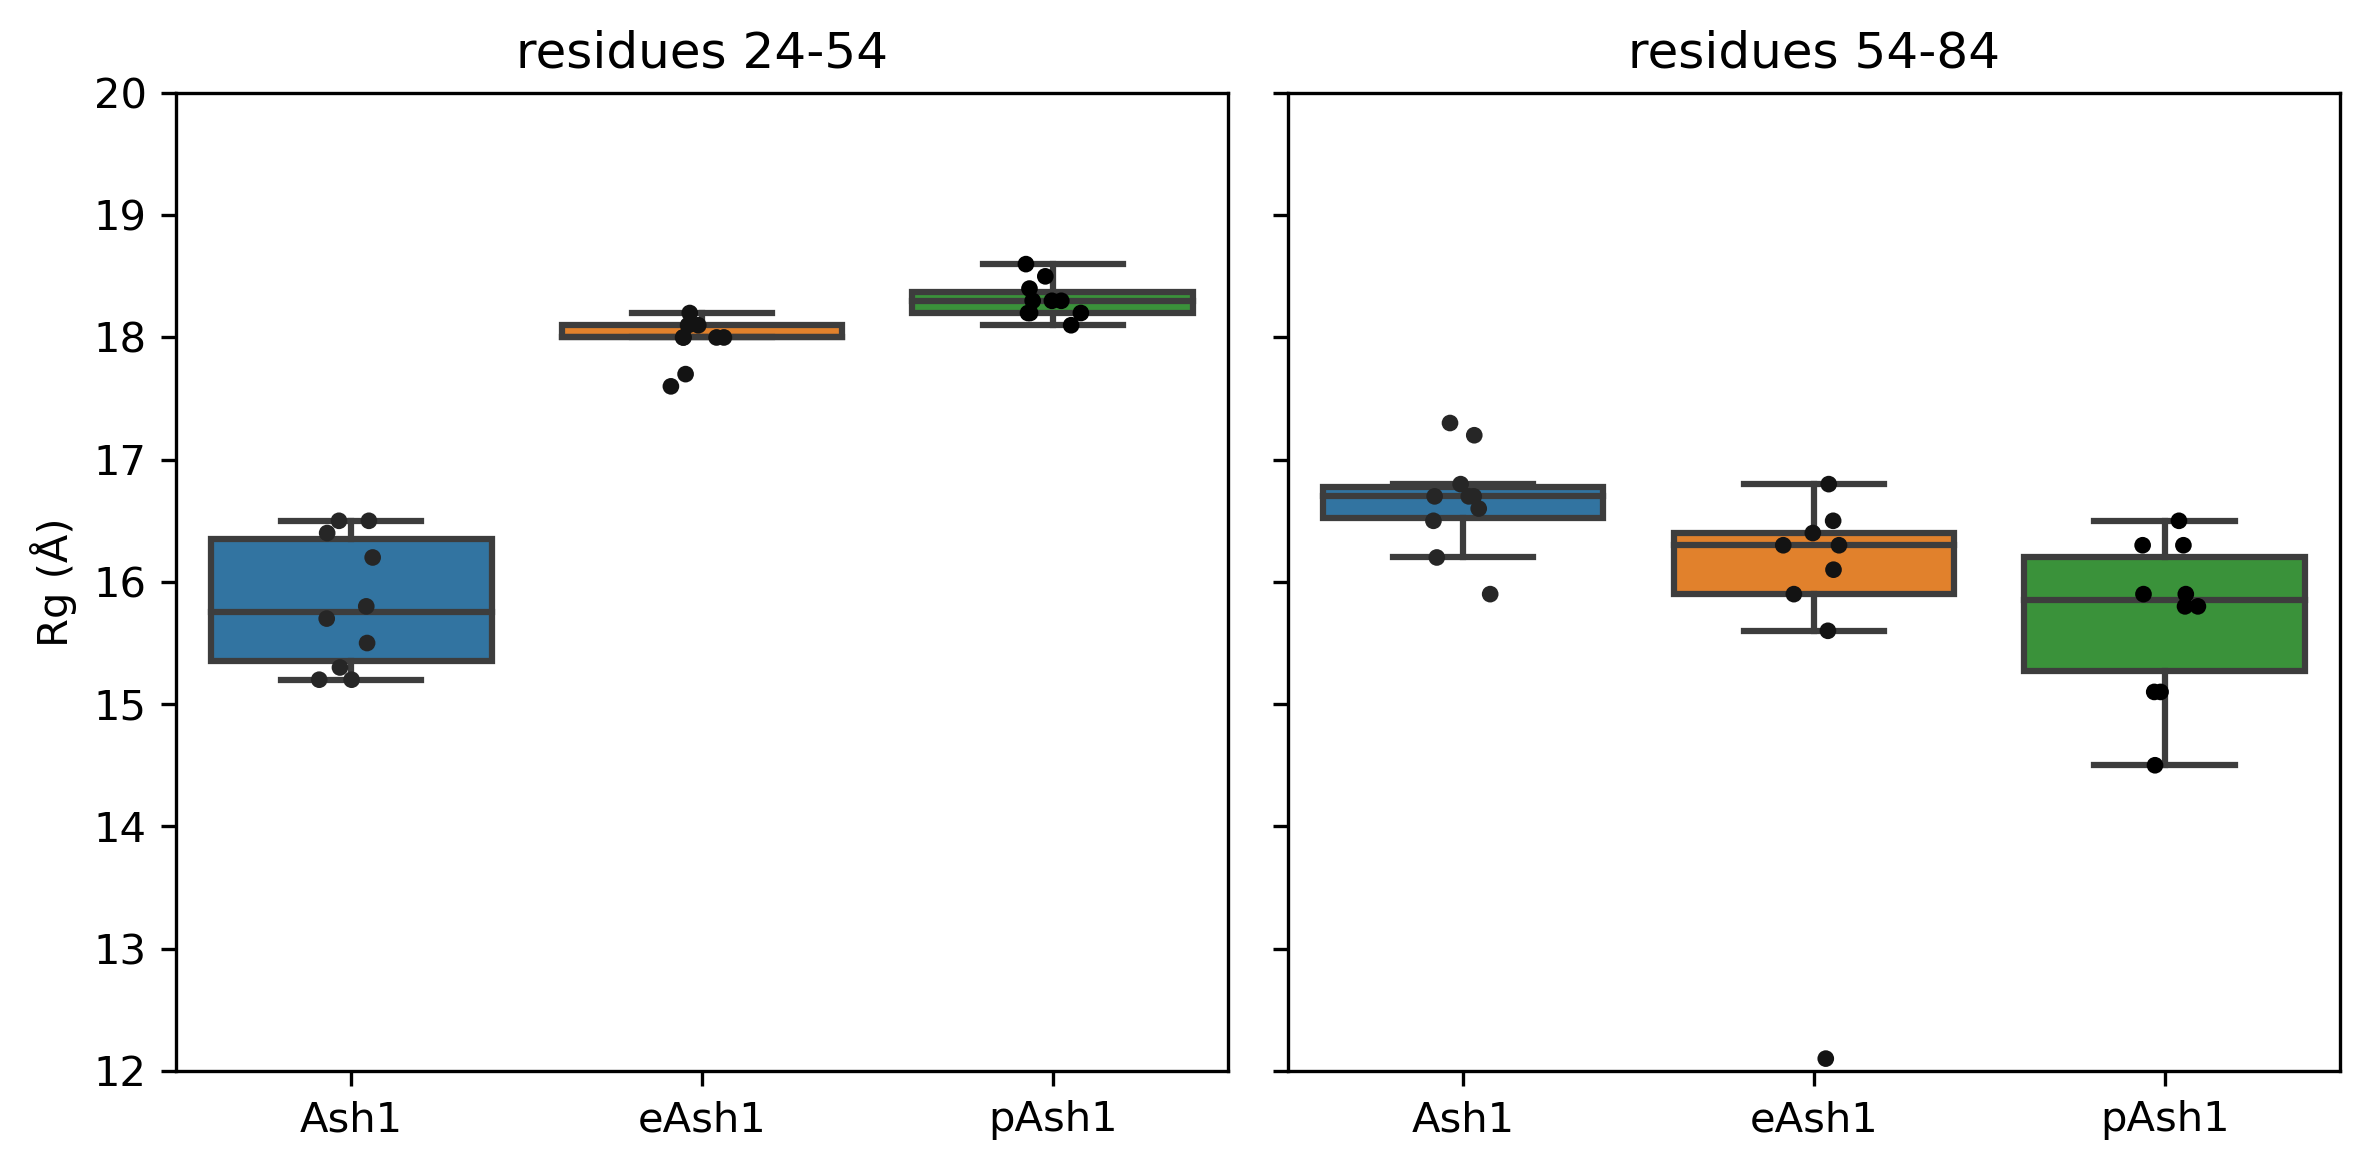

In [25]:
## generate graphic of per-replicate Rg values for subregions of Ash1 in different phosphostates (PANEL S5D)
fig, axes = plt.subplots(1, 2, figsize = (8, 4), dpi = 300, sharey = True)

# plot segment 1 Rgs (residues 24-54)
sns.boxplot(ax = axes[0], data = seg1, orient = 'v', showfliers = False)
sns.stripplot(ax = axes[0], data = seg1, orient = 'v', jitter = True, color = 'k', s = 4)

# plot segment 2 Rgs (residues 54-84)
sns.boxplot(ax = axes[1], data = seg2, orient = 'v', showfliers = False)
sns.stripplot(ax = axes[1], data = seg2, orient = 'v', jitter = True, color = 'k', s = 4)

axes[0].set_ylim([12, 20])
axes[0].set_ylabel('Rg (Å)')

axes[0].set_title('residues 24-54')
axes[1].set_title('residues 54-84')

plt.tight_layout()
#ax.legend(loc = 'best', prop={'size': 10})

plt.savefig('Ash1_segments_Rg_boxplots_S5D.pdf', format = 'pdf', dpi = 300)
plt.show()